8.1 Xây dựng mô hình trên level kí tự

Sau đây ta sẽ áp dụng mô hình LSTM trong việc dự báo từ tiếp theo của một đoạn hoặc câu văn dựa vào bối cảnh của từ là những từ liền trước nó.

Dữ liệu được sử dụng là bộ truyện alice ở xứ sở kỳ diệu đã được nhà xuất bản publish nên không vi phạm bản quyền. Mô hình dự báo sẽ được xây dựng trên level kí tự. Bên dưới, chúng ta sẽ đọc dữ liệu và chuyển các kí tự về in thường để giảm thiểu kích thước bộ mã hóa mà vẫn đảm bảo được nội dung văn bản. Dữ liệu được lưu trong kernel là file alice.

In [31]:
import numpy 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import os

filename = 'alice'
raw_text = open(filename).read().lower()

Một dictionary gồm 59 kí tự được sử dụng để mã hóa các kí tự trong bộ truyện. Key của các kí tự là số thứ tự của chúng trong dictionary. Trong sơ đồ thiết kế mạng nơ ron một kí tự được mã hóa bằng một vector đơn vị sao cho phần từ 1 sẽ xuất hiện tại vị trí của key trong bộ từ điển và 0 là các phần tử còn lại

In [32]:
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
print('number of letters: ', len(char_to_int))
print(char_to_int)

number of letters:  46
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '0': 11, '3': 12, ':': 13, ';': 14, '?': 15, '[': 16, ']': 17, '_': 18, '`': 19, 'a': 20, 'b': 21, 'c': 22, 'd': 23, 'e': 24, 'f': 25, 'g': 26, 'h': 27, 'i': 28, 'j': 29, 'k': 30, 'l': 31, 'm': 32, 'n': 33, 'o': 34, 'p': 35, 'q': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'w': 42, 'x': 43, 'y': 44, 'z': 45}


Chúng ta nhận thấy rằng mục đích chỉ là dự báo từ tiếp theo do đó cần lọc bỏ những kí tự không quyết định đến nghĩa của 1 từ chẳng hạn như các dấu đặc biệt #, $, *, @, /. Như vậy, sẽ cần một bước chuẩn hóa dữ liệu nhằm giảm thiểu nhiễu và số lượng các khả năng có thể ở đầu ra. Điều này sẽ giúp cải thiện chất lượng và độ chính xác trong dự báo của mô hình đáng kể. Việc chuẩn hóa sẽ bao gồm như sau:

Chỉ giữ lại các kí tự chữ cái vì chúng có ảnh hưởng đến nội dung của 1 từ.
Chỉ giữ lại các dấu câu là ., !, ? vì chúng thể hiện các loại câu khác nhau và sẽ ảnh hưởng đến từ tiếp theo khi dự báo. Chẳng hạn nếu dấu câu là ? thì khả năng cao từ tiếp theo sẽ là yes hoặc no. Dấu câu là . thì từ tiếp theo có thể là một đại từ nhân xưng i, you, we, they, he, she, it.
Giữ lại các dấu ,' ' vì chúng giúp tách các từ và tách các thành phần câu.
Chuẩn hóa lại các các chữ số về 1 chữ số duy nhất là 0 vì các con số là ngẫu nhiên và không dự báo được. Chúng ta chỉ có thể dự báo ở vị trí nào có khả năng là số.
Các kí tự nằm ngoài số liệt kê trên sẽ đưa vào nhóm unk tức unknown.

In [33]:
import string
string.ascii_lowercase
# string.digits
# string.punctuation
chars_new = list(string.ascii_lowercase) + ['0', '.', ',', ' ', '!', '?', 'unk']
chars_to_int = dict((v, k) for k, v in enumerate(chars_new))
int_to_chars = dict((k, v) for k, v in enumerate(chars_new))
print('character to int:', chars_to_int)
print('int to character:', int_to_chars)
# def _clean_char(text):
#     return 1


character to int: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '.': 27, ',': 28, ' ': 29, '!': 30, '?': 31, 'unk': 32}
int to character: {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '0', 27: '.', 28: ',', 29: ' ', 30: '!', 31: '?', 32: 'unk'}


In [34]:
n_chars = len(raw_text)
n_vocab = len(chars_new)
print('Total characters: ', n_chars)
print('Total Vocab: ', n_vocab)

Total characters:  148574
Total Vocab:  33


Như vậy sau chuẩn hóa văn bản của chúng ta sẽ bao gồm 163693 từ và 33 kí tự. Tiếp theo là một hàm chuyển hóa một câu thành một vector chỉ số các kí tự.

In [35]:
def _encode_sen(text):
    text = text.lower()
    sen_vec = []
    for let in text:
        if let in chars_new[:-1]:
            idx = chars_to_int[let]
        else:
            idx = chars_to_int['unk']
        sen_vec.append(idx)
    return sen_vec

x_test = _encode_sen('Alice is a wonderful story. #')
print(x_test)

[0, 11, 8, 2, 4, 29, 8, 18, 29, 0, 29, 22, 14, 13, 3, 4, 17, 5, 20, 11, 29, 18, 19, 14, 17, 24, 27, 29, 32]


In [36]:
def _decode_sen(vec):
    text = []
    for i in vec:
        let = int_to_chars[i]
        text.append(let)
    text = ''.join(text)
    return text

_decode_sen(x_test)

'alice is a wonderful story. unk'

Để đồng nhất độ dài đầu vào cho mô hình cần tạo ra các chuỗi kí tự (window input) với với độ dài là 100. Mục đích của chúng ta là dự báo kí tự tiếp theo từ 100 kí tự đầu vào. Mỗi một phiên dự báo window input sẽ được tịnh tiến lên 1 kí tự để thu được các kí tự dự báo liên tiếp nhau và từ đó ghép lại thành một câu hoàn chỉnh.

In [37]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    # Lấy ra 100 kí tự liền trước
    seq_in = raw_text[i:i + seq_length]
    # Lấy ra kí tự liền sau 100 kí tự đó
    seq_out = raw_text[i + seq_length]
    dataX.append(_encode_sen(seq_in))
    dataY.append(_encode_sen(seq_out)[0])
    n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
print(dataY)

Total Patterns:  148474
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 11, 4, 22, 8, 18, 29, 2, 0, 17, 17, 14, 11, 11, 32, 32, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 19, 7, 4, 29, 12, 8, 11, 11, 4, 13, 13, 8, 20, 12, 29, 5, 20, 11, 2, 17, 20, 12, 29, 4, 3, 8, 19, 8, 14, 13, 29, 32, 27, 26, 32, 32, 32, 32, 32, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 2, 7, 0, 15, 19, 4, 17, 29, 8, 32, 32, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 3, 14, 22, 13, 29, 19, 7, 4, 29, 17, 0, 1, 1, 8, 19, 32, 7, 14, 11, 4, 32, 32, 32, 29, 29, 0, 11, 8, 2, 4, 29, 22, 0, 18, 29, 1, 4, 6, 8, 13, 13, 8, 13, 6, 29, 19, 14, 29, 6, 4, 19, 29, 21, 4, 17, 24, 29, 19, 8, 17, 4, 3, 29, 14, 5, 29, 18, 8, 19, 19, 8, 13, 6, 29, 1, 24, 29, 7, 4, 17, 29, 18, 8, 18, 19, 4, 17, 32, 14, 13, 29, 19, 7, 4, 29, 1, 0, 13, 10, 28, 29, 0, 13, 3, 29, 14, 5, 29, 7, 0, 21, 8, 13, 6, 29, 13, 14, 19, 7, 8, 13,

In [38]:
# reshape X to be [samples, time steps, features]
X_train = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X_train = X_train / float(n_vocab)
# one hot encode the output variable
y_train = to_categorical(dataY)
print('X [samples, time steps, features] shape: ', X_train.shape)
print('Y shape: ', y_train.shape)

X [samples, time steps, features] shape:  (148474, 100, 1)
Y shape:  (148474, 33)


In [39]:
print(type(X_train))
print(type(y_train))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


C:\Users\MAC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: The number of FixedLocator locations (32), usually from a call to set_ticks, does not match the number of ticklabels (33).

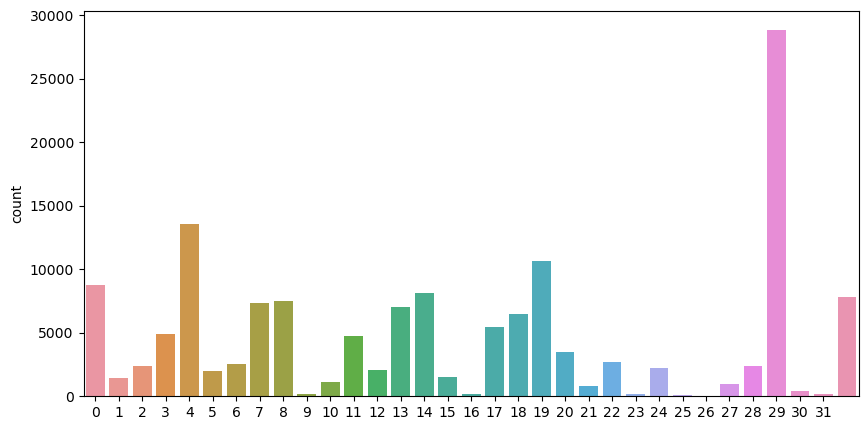

In [40]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
sn.countplot(np.array(dataY))
plt.xticks(np.arange(32),np.array(chars_new))

8.2. Mô hình LSTM


Xây dựng một kiến trúc model gồm một layer LSTM kết nối tới 1 layer Dropout và kết nối tới Dense layer ở cuối. Với mục đích là để chúng ta hiểu về lý thuyết LSTM nên tôi chọn mô hình có cấu trúc đơn giản nhất.

In [43]:
model = Sequential()
model.add(LSTM(256, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

C:\Users\MAC\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 33)             │         8,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,673 (1.04 MB)

 Trainable params: 272,673 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
filepath = 'weights-improvement-{epoch:02d}-{loss:.4f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callback_list = [checkpoint]

In [46]:
model.fit(X_train, y_train, epochs = 5, batch_size = 128, validation_split=0.33, callbacks = callback_list, verbose = 1)


Epoch 1/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 471s 600ms/step - accuracy: 0.1903 - loss: 2.9548 - val_accuracy: 0.1899 - val_loss: 2.8002
Epoch 2/5


C:\Users\MAC\AppData\Roaming\Python\Python39\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


778/778 ━━━━━━━━━━━━━━━━━━━━ 414s 533ms/step - accuracy: 0.2109 - loss: 2.7631 - val_accuracy: 0.2313 - val_loss: 2.6985
Epoch 3/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 496s 638ms/step - accuracy: 0.2380 - loss: 2.6738 - val_accuracy: 0.2453 - val_loss: 2.6359
Epoch 4/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 646s 823ms/step - accuracy: 0.2561 - loss: 2.6089 - val_accuracy: 0.2669 - val_loss: 2.5766
Epoch 5/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 657s 844ms/step - accuracy: 0.2670 - loss: 2.5629 - val_accuracy: 0.2746 - val_loss: 2.5332


In [57]:
import numpy as np
base_word = ' whether the pleasure of making a'

def _predict_let(text, len_sen = 1):
    text_for = []
    for i in range(len_sen):
        x_input = np.array(_encode_sen(text)[-100:])/float(n_vocab)
        print(x_input)
        if x_input.shape[0] < 100:
            x_input = np.concatenate((np.zeros(100-x_input.shape[0]), x_input), axis = 0)
        x_input = np.expand_dims(np.expand_dims(x_input, -1), 0)
        print(x_input)
        y_prob = model.predict(x_input)
        print(y_prob)
        print(np.argmax(y_prob, axis = 1))
        y_let = int_to_chars[np.argmax(y_prob, axis = 1)[0]]
        text = text + y_let
    return text[len_sen:]

_predict_let(base_word, 100)

[0.87878788 0.66666667 0.21212121 0.12121212 0.57575758 0.21212121
 0.12121212 0.51515152 0.87878788 0.57575758 0.21212121 0.12121212
 0.87878788 0.45454545 0.33333333 0.12121212 0.         0.54545455
 0.60606061 0.51515152 0.12121212 0.87878788 0.42424242 0.15151515
 0.87878788 0.36363636 0.         0.3030303  0.24242424 0.39393939
 0.18181818 0.87878788 0.        ]
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]


'e  and toe  and the  and toe  and'